In [4]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP

In [2]:
with open("/home/bruce1996/nvme2/scRNA/seurat_hvgs_list.pickle",'rb') as f :
    hvgs = pickle.load(f)
f.close()

with open('/home/bruce1996/nvme2/scRNA/GSE149614_coding_gene_hepatocyte_normalized.pkl', 'rb') as f :
    exp_m = pickle.load(f)
f.close()

with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()

metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
metadata = metadata.loc[exp_m.columns,:]
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

### Exam HVG / voted gene mean & variance

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
mean = exp_m.mean(axis=1)
variance = exp_m.var(axis=1)
df = pd.concat([pd.DataFrame({'Mean' : mean[hvgs],'Variance' : variance[hvgs],'Label' : ['HVG'] * len(hvgs)}),
                pd.DataFrame({'Mean' : mean[voted_gene],'Variance' : variance[voted_gene],'Label' : ['Voted gene'] * len(voted_gene)})])

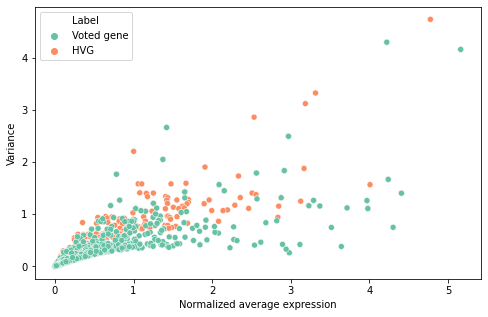

In [4]:
plt.figure(figsize=(8,5))
sns.scatterplot(data = df,x='Mean',y='Variance',hue='Label',palette='Set2',hue_order=['Voted gene','HVG'])
plt.xlabel("Normalized average expression")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/mean_variance_scatter_plot.png",dpi=300)

### Spearman correlation between gene variance & vote number

In [27]:
from scipy import stats

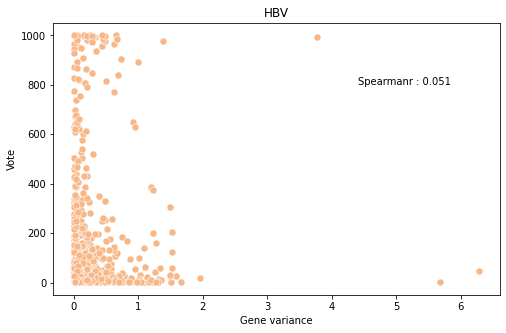

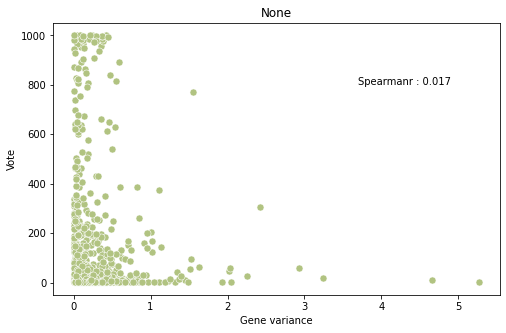

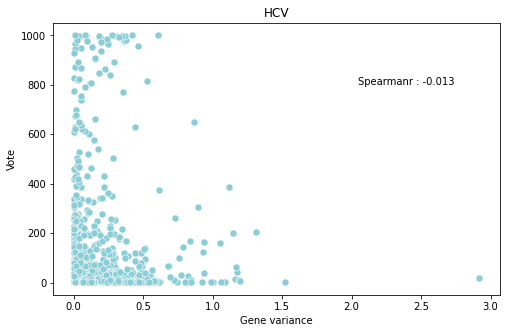

In [38]:
vote_exp_m = exp_m.loc[voted_gene,:]
colormap = ['#F7B787','#B1C381','#8ACDD7']
for idx,virus in enumerate(metadata.virus.unique()) :
    df = vote_exp_m.loc[:,np.where(metadata.virus == virus,True,False)]
    plot_df = pd.DataFrame({'Variance' : df.var(axis=1),'Vote' : vote.loc[voted_gene,'Vote'].values},index=voted_gene)
    #plot
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=plot_df,x='Variance',y='Vote',s=50,color=colormap[idx])
    rho,pval = stats.spearmanr(plot_df['Variance'].values, plot_df['Vote'].values)
    plt.title(virus)
    plt.xlabel('Gene variance')
    plt.text(plot_df['Variance'].max() * 0.7,800,"Spearmanr : %0.3f" % rho)
    plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/%s_scc_of_gene_variance_and_vote_number.pdf" % virus,dpi=300,format='pdf')

### Seurat HVGs UMAP clustering

In [3]:
from matplotlib_venn import venn2

/home/bruce1996/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bruce1996/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bruce1996/anaconda3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDepreca

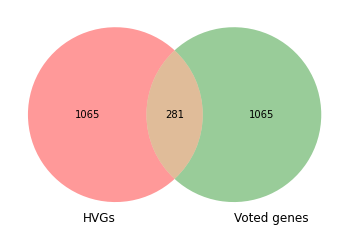

In [9]:
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
venn2([set(hvgs),set(voted_gene)],set_labels=["HVGs","Voted genes"])
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_hvgs_venn_diagram.pdf",format='pdf',dpi=300)

In [3]:
metadata = metadata.loc[exp_m.columns,:]
sample = metadata.index[np.where(metadata['Advance_celltype'] != 'cholangiocyte ',True,False)]
exp_m = exp_m.loc[:,sample]

In [9]:
voted_exp_m = exp_m.loc[voted_gene,:]
metadata = metadata.loc[voted_exp_m.columns,:]
reducer = UMAP()
embedding = reducer.fit_transform(voted_exp_m.T)
embedding_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1]},index=voted_exp_m.columns)
embedding_df = pd.concat([embedding_df,metadata],axis=1)
embedding_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_without_cholangiocyte_umap_embedding.txt",sep='\t')

In [ ]:
#embedding_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvgs_umap_embedding.txt",sep='\t',index_col=0)
fig,axs = plt.subplots(2,2,figsize=(24,15))
conditions = ['virus','stage','Advance_celltype','patient']
for idx,ax in enumerate(axs.ravel()):
    condition = conditions[idx]
    sns.scatterplot(data=embedding_df,x='UMAP1',y='UMAP2',hue=condition,palette='rainbow_r',
                    hue_order = sorted(set(embedding_df[condition].unique())),ax=ax)
#plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_without_cholangiocyte_umap_scatterplot.png",dpi=300)
plt.show()

### calculate Seurat clustering result

In [5]:
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score,silhouette_score
from sklearn.cluster import KMeans
import random
import hdbscan
from umap import UMAP

def metadata_coverter(metadata) :
    converter = {}
    for idx,component in enumerate(sorted(metadata.unique())) :
        converter[component] = idx
    return converter

def calculate_umap_clustering_result(exp_matrix,ground_truth) :
    """_summary_

    Args:
        exp_matrix (pd.DataFrame): input expression matrix 
        ground_truth (np.array): metadata of samples
    """    
    reducer = UMAP(n_jobs=32,n_components=30)
    embedding = reducer.fit_transform(exp_matrix)
    hdbscan_labels = hdbscan.HDBSCAN().fit_predict(embedding)


    metric_dict = {}
    metric_dict['ARI'] = adjusted_rand_score(ground_truth,hdbscan_labels)
    metric_dict['NMI'] = normalized_mutual_info_score(ground_truth,hdbscan_labels)

    return metric_dict

In [21]:
candidate_gene = list(set(vote.index[vote['Vote'] > 200]).intersection(exp_m.index))
condition = 'patient'
title_dict = {'virus' : "Virus type clustering (152 genes)",'patient' : "HCC patient clustering (152 genes)"}
stage_d = metadata_coverter(metadata[condition])
y_true = metadata.loc[exp_m.columns,condition].replace(stage_d).values
random_clustering_comparison = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/%s_highly_voted_genes_random_sampling_cluster_result.txt" % condition,sep='\t',index_col=0)
random_clustering_result = random_clustering_comparison.iloc[:100,:]
voted_gene_res = random_clustering_comparison.loc['Voted genes',:]
seurat_res = random_clustering_comparison.loc['Seurat HVGs',:]

0 random sample clustering result outperform the clustering result from voted genes
0 random sample clustering result outperform the clustering result from voted genes


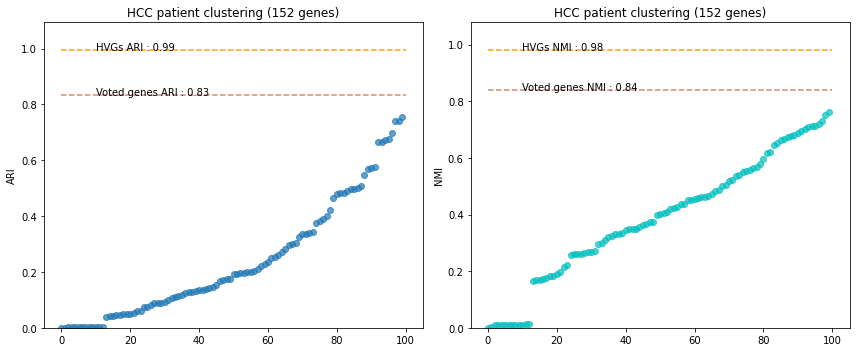

In [22]:
fig,axs = plt.subplots(1,2,figsize = (12,5))
axes = axs.ravel()

for m_idx,metric in enumerate(['ARI','NMI']) :
    ax = axes[m_idx]
    metric_result = random_clustering_result[metric].values
    random_res = sorted(metric_result)
    print("%d random sample clustering result outperform the clustering result from voted genes" % sum(random_res > seurat_res[metric]))
    x = np.arange(100)
    if metric == 'NMI' :
        ax.scatter(x,random_res,alpha=0.7,c='c')
    else :
        ax.scatter(x,random_res,alpha=0.7)
    ax.hlines(y=seurat_res[metric],xmin=0,xmax=100,linestyles='--',colors='orange')
    ax.hlines(y=voted_gene_res[metric],xmin=0,xmax=100,linestyles='--',colors='#CD8D7A')
    ax.set_ylabel(metric)
    ax.set_title(title_dict[condition])
    #ax.set_title("Seurat HVGs UMAP + HDBSCAN clustering result")
    ax.set_ylim([random_res[0] * 0.9,max(random_clustering_comparison[metric])*1.1])
    ax.text(10,seurat_res[metric],"HVGs %s : %0.2f" % (metric,seurat_res[metric]))
    ax.text(10,voted_gene_res[metric],"Voted genes %s : %0.2f" % (metric,voted_gene_res[metric]))
plt.tight_layout()

plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/highly_voted_genes_random_sampling_cluster_result_%s.pdf" % condition,
            format='pdf',dpi=300,bbox_inches='tight')


In [79]:
len(candidate_gene)

152